# **Orientación calles**

**OSMnx** es una librería de Python para descargar y procesar información disponible en [**OpenStreetMap**](https://www.openstreetmap.org/). A continuación se muestra un ejemplo de como usar la librería para crear **diagramas de roseta** con la frecuencia en la que las calles de una ciudad se encuentran en una dirección.

Información adicional de **OSMnx**, se pueden encontrar en la [**documentación oficial**](https://osmnx.readthedocs.io/en/stable/),  [**página web del autor**](https://geoffboeing.com/) y [**ejemplos**](https://github.com/gboeing/osmnx-examples) adicionales.

## **1.** Importar librerías

In [1]:
import osmnx as ox
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm # Barra progreso
%matplotlib inline
ox.config(log_console=True)

## **2.** Descargar información
La función `ox.graph_from_place()` descarga un grafo de la red vial de un lugar específico. A esta función se le suministran dos argumentos: el nombre de la ciudad o municipio como cadena de caracteres (`"Chía, Cundinamarca, Colombia"`) y el tipo de red; para este ejemplo se descarga un grafo de las calles en las cuales  es posible conducir (excluyendo entradas privadas) `network_type = "drive"`.

### **2.1** Construir diccionario con las ciudades
En este caso descarga información de todos los municipios de Sabana Centro, sin embargo, el código se puede adaptar para descargar información de cualquier ciudad al pasar un diccionario con los nombres de la siguietnte manera:
```
fnames = {"Barranquila": "Barranquilla, Atlántico, Colombia",
          "Guayaquil": "Guayaquil, Guayas, Ecuador"}
```
Comprobar que las descripciones de la siguiente tabla correspondan a los sitios elegidos, de otra manera intentar con un nombre mas específico.

In [2]:
municipios = ["Cajicá",
             "Chía",
             "Cogua",
             "Cota",
             "Gachancipá",
             "Nemocón",
             "Sopó",
             "Tabio",
             "Tenjo",
             "Tocancipá",
             "Zipaquirá"]

fnames = dict(zip(municipios,
                 [name + ", Cundinamarca, Colombia" for name in municipios]
                )
            )

gdf = ox.geocode_to_gdf(list(fnames.values()))
gdf[["display_name", "class"]]

,display_name,class
0,"Cajicá, Sabana Centro, Cundinamarca, Región An...",boundary
1,"Chía, Sabana Centro, Cundinamarca, Región Andi...",boundary
2,"Cogua, Sabana Centro, Cundinamarca, Región And...",boundary
3,"Cota, Sabana Occidente, Cundinamarca, Región A...",boundary
4,"Gachancipá, Sabana Centro, Cundinamarca, Regió...",boundary
5,"Nemocón, Sabana Centro, Cundinamarca, Región A...",boundary
6,"Sopó, Sabana Centro, Cundinamarca, Región Andi...",boundary
7,"Tabio, Sabana Centro, Cundinamarca, Región And...",boundary
8,"Tenjo, Sabana Centro, Cundinamarca, Región And...",boundary
9,"Tocancipá, Sabana Centro, Cundinamarca, Región...",boundary


## **2.2.** Descargar grafos y añadir direcciones
Se descarga información de cada municipio y se construye un grafo, del cual se calcula la orientación de cada calle basandose en la ubicación de las intersecciones y se añade como un atributo `"bearing"`.
> El tiempo de ejecución de esta celda depende de la extensión de las ciudades a descargar. Para Sabana Centro es aproximandamente *1 minuto*.

In [4]:
graphs = dict()
for name , query in tqdm(fnames.items(), "Municipios descargados"):
    G = ox.graph_from_place(query, network_type="drive")
    G = ox.add_edge_bearings(ox.get_undirected(G))
    graphs[name] = G

Municipios descargados: 100%|██████████| 11/11 [01:10<00:00,  6.43s/it]


## **3.** Definir funciones necesarias
### **3.1.** Obtener histograma de frecuencias para las direcciones de las calles.
Dado que la información de orientación de las calles se encuentra almacenada en el grafo, se construye una tabla (DataFrame) para facilitar su manipulación. Además, debido a que el objetivo es crear un diagrama de roseta en las 4 dirección, se añada una dirección opuesta (±180) para cada calle. Así una calle que tenga una dirección de 45° (Noreste) también será incluida cuando se cuenten las calles en la dirección 225° (Suroeste).
Finalmente, se realiza el conteo de las calles que se encuentran en cada intervalo, teniendo la posibilidad de ponderarlas por longitud.

In [42]:
# Obtener ángulo opuesto
def inv_direc(x):
    return x + 180 if x < 180 else x - 180

# Crear DataFrame con las direcciones para cada ciudad.
def extract_orientation(graphs, ponderar_long):
    orientaciones = {}
    for name, G in graphs.items():
        orientacion = []
        if ponderar_long: # Ponderar por longitud
            for u,v,d in G.edges(data=True):
                orientacion.extend([d['bearing']] * int(d['length']))
        else:
            orientacion = [d['bearing'] for u,v,d in G.edges(data=True)] 
        df = pd.Series(orientacion)
        orientaciones[name] = pd.concat([df, df.map(inv_direc)]).reset_index(drop='True')
    
    return orientaciones

# Conteo de las orientaciones que se encuentran en cada intervalo, por defecto (n = 36)
def count_and_merge(n, bearings):
    n = n * 2
    bins = np.arange(n + 1) * 360 / n
    count, _ = np.histogram(bearings, bins=bins)
    
    count = np.roll(count, 1)
    return count[::2] + count[1::2]

### **3.2.** Generar histograma orientaciones cada municipio.
Se usa la librería [matplotlib](https://matplotlib.org/) para generar un histograma que será guardado como *subplot*.  

In [19]:
# Dibujar histograma en coordenadas polares
def polar_plot(ax, bearings, scale, n=36, title=''):

    bins = np.arange(n + 1) * 360 / n
    count = count_and_merge(n, bearings)
    _, division = np.histogram(bearings, bins=bins)
    frequency = count / count.sum()
    
    # Número de barras y su ancho correspondiente
    division = division[0:-1]
    width =  2 * np.pi / n
    
    # Inico y sentido (N=0°)
    ax.set_theta_zero_location('N')
    ax.set_theta_direction('clockwise')
    
    # Generar histrograma
    x = division * np.pi / 180
    bars = ax.bar(x, height=frequency, width=width, align='center', bottom=0, zorder=2,
                  color='#003366', edgecolor='k', linewidth=0.5, alpha=0.7)
    
    ax.set_ylim(top=frequency.max())
    
    # Ajustar atributos (Roseta de vientos, formato de subtitulo, orden de visualización)
    title_font = {'size':4*scale, 'weight':'bold'}
    xtick_font = {'size':4*scale, 'weight':'bold', 'zorder':3}
    
    ax.set_title(title.upper(), y=1.1, fontdict=title_font)
    
    xticklabels = ['N', '', 'E', '', 'S', '', 'W', '']
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(labels=xticklabels, fontdict=xtick_font)
    ax.tick_params(axis='x', which='major', pad=-2)
    ax.set_yticklabels([])

In [57]:
def plot_orientations(orientaciones, title, spscale = 3):
    n = len(fnames)
    ncols = int(np.ceil(np.sqrt(n)))
    nrows = int(np.ceil(n / ncols))
    figsize = (ncols * spscale, nrows * spscale)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, subplot_kw={'projection':'polar'})

    # plot each city's polar histogram
    for ax, place in zip(axes.flat, sorted(fnames.keys())):
        polar_plot(ax, orientaciones[place].dropna(), spscale, title=place)

    # add super title and save full image
    suptitle_font = {'fontsize':6*spscale, 'fontweight':'bold', 'y':1}
    fig.suptitle(title, **suptitle_font)
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.35)
    plt.show()

## **4.** Visualizar orientaciones

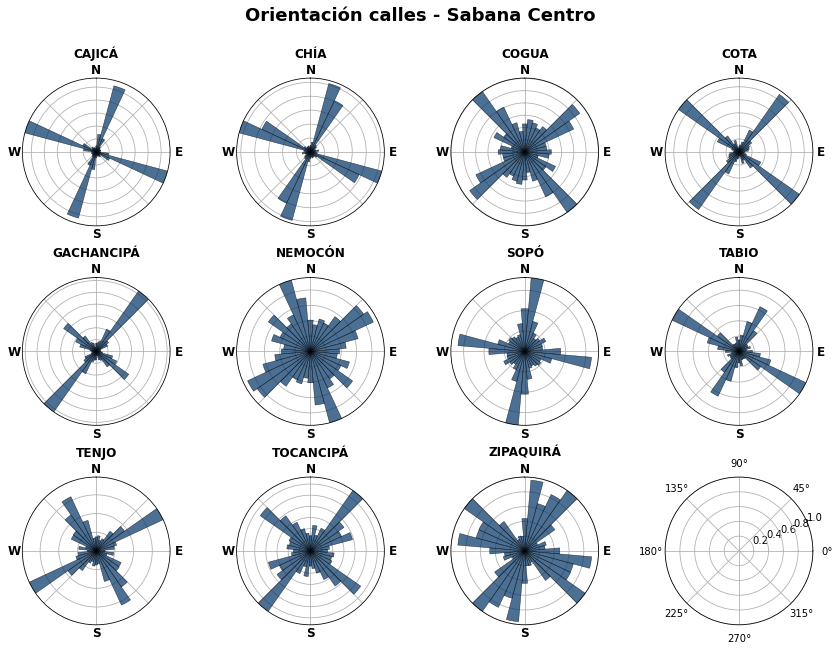

In [58]:
orientaciones = extract_orientation(graphs, False)
plot_orientations(orientaciones, "Orientación calles - Sabana Centro", 3)

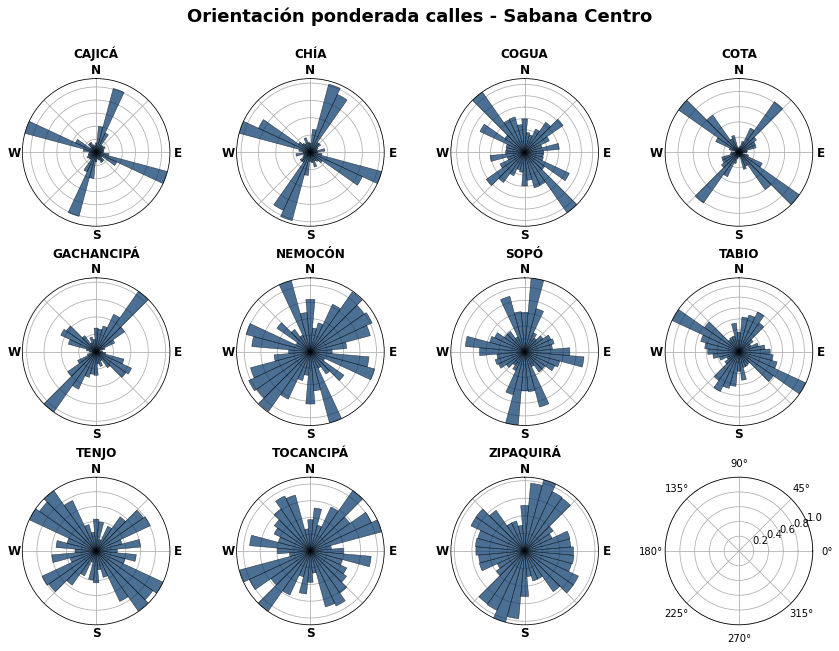

In [59]:
orientaciones_pond = extract_orientation(graphs, True)
plot_orientations(orientaciones_pond, "Orientación ponderada calles - Sabana Centro")

## **5** Orden de orientación
La metríca de orden de orientación es una medida de entropía normalizada [(Boeing, 2019)](https://appliednetsci.springeropen.com/articles/10.1007/s41109-019-0189-1), que indica sí las calles se encuentran distribuidas en todas las direcciones (ordén de  orientación = 1), o si por el contrario las calles se siguen un patron cuadricular perfecto (ordén de orientación = 0).

In [65]:
def orientation_order(intervals):
    P = intervals/sum(intervals)
    H_0 = -sum([Pi*np.log(Pi) for Pi in P])
    Hmax = np.log(len(intervals))
    Hg = np.log(4)
    result = ((H_0 - Hg)/(Hmax - Hg))**2
    
    return result

oorder = dict()
for name in fnames.keys():
    oorder[name] = orientation_order(count_and_merge(36, orientaciones[name]))
pd.DataFrame(data=oorder.items(), columns = ["Municipio", "Ordén de orientación"])

,Municipio,Ordén de orientación
0,Cajicá,0.498467
1,Chía,0.527651
2,Cogua,0.914561
3,Cota,0.648028
4,Gachancipá,0.696821
5,Nemocón,0.952711
6,Sopó,0.876445
7,Tabio,0.788477
8,Tenjo,0.835988
9,Tocancipá,0.899746
